# MNIST Example

This tutorial walks you through the different steps involved in building a spiking neural network in `sinabs`.

Lets start by installing all the necessary packages. 

In [33]:
# To keep this tutorial clean and succint, we are directing the output of the `pip` command to a file `install_log`. 
# You might want to get rid of the output redirection if you want to make sure there are no errors.
# %pip install -r mnist-requirements.txt

%pip install -r mnist-requirements.txt > install_log

You should consider upgrading via the '/home/martino/.pyenv/versions/3.7.5/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Training a model in `sinabs`

###  Define a `PyTorch` Model

`sinabs` is a `PyTorch` based library so. So we start by simply defining our model in `PyTorch`. In this example we instantiate a `nn.Sequential` model with 3 `Conv2d` layers and two dense (`nn.Linear`) layers.

In [34]:
import torch.nn as nn

ann = nn.Sequential(
    nn.Conv2d(1, 20, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    nn.Conv2d(20, 32, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    nn.Conv2d(32, 128, 3, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    nn.Flatten(),
    nn.Linear(128, 500, bias=False),
    nn.ReLU(),
    nn.Linear(500, 10, bias=False),
)

### Define DataSet

As the title of this tutorial states, we will train the above model for `MNIST` digit classification task. We borrow the `Dataset` definition from torchvision. Here since we intend to do a spiking neural network simulation, we override this `Dataset` to also *optinally* return a `spike raster` instead of an image. 

In this implementation of the `Dataset` we use *rate coding* to generate a series of spikes at each pixel of the image proportional to it's gray level.

In [35]:
import numpy as np
from PIL import Image
from torchvision import datasets

class MNIST_Dataset(datasets.MNIST):

    def __init__(self, root, train = True, spiking=False, tWindow=100):
        datasets.MNIST.__init__(self, root, train=train, download=True)
        self.spiking=spiking
        self.tWindow = tWindow


    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        if self.spiking:
            img = (np.random.rand(self.tWindow, 1, *img.size()) < img.numpy()/255.0).astype(float)
            img = torch.from_numpy(img).float()
        else:
            # Convert PIL image to tensor
            img = torch.from_numpy(img.numpy()).float()
            img.unsqueeze_(0)

        return img, target

### Train the model

We start by first training the `ann` over the `MNIST` image dataset. **Note** here that we are not yet using spiking input (`spiking=False`). This is vanilla training for starndard image classification.

In [36]:
from torch.utils.data import DataLoader

# Define test dataset loader
train_loader = DataLoader(
    MNIST_Dataset('./data', train=True, spiking=False),
    batch_size=128, shuffle=True)

We iterate over our data loader `trian_loader` and train our parameters using the `Adam` optimizer with a learning rate of `1e-4`. Since the last layer in our network has no specific activation function defined, `cross_entropy` loss is a good candidate to train our network.

In [37]:
import tqdm
import torch
import torch.nn.functional as F
import torch.optim as optim


try:
    # Load a pre-trained model to save time if you have already have one.
    ann.load_state_dict(torch.load("mnist_params.pt"))
except:
    # Train the model

    ann.train()

    optim = torch.optim.Adam(ann.parameters(), lr=1e-4)

    n_epochs = 3

    for n in tqdm.notebook.tqdm(range(n_epochs)):
        pbar = tqdm.notebook.tqdm(train_loader)
        # Iterate over data
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            output = ann(data)
            optim.zero_grad()

            # Add loss to the total loss
            loss = F.cross_entropy(output, target)

            # Propagate loss backwards
            loss.backward()

            # Update weights
            optim.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # Compute the total correct predictions
            correct = pred.eq(target.view_as(pred)).sum().item()

            pbar.set_postfix({"loss": loss.item(), "accuracy": correct/(len(target))})
            
    # Save model parameters
    torch.save(ann.state_dict(), "mnist_params.pt")

Training this model on `MNIST` is fairly straight forward and you should reach accuracies of around `>98%` within a small number of epochs. In the script above we only train for 3 epochs!

In order to test the accuracy of our model, we first define a convenience method to test and report its performance.

In [38]:
import warnings

# Convenience method to test the model
def test(model, data_loader, num_batches=None):
    model.eval()
    correct = 0
    batch_count = 0

    with torch.no_grad():
        # Iterate over data
        pbar = tqdm.notebook.tqdm(data_loader)
        for data, target in pbar:
            if data_loader.dataset.spiking:
                if len(data.size()) > 4:
                    warnings.warn("Warning: Batch size needs to be 1, only first sample used.", stacklevel=2)
                    data = data[0]
                    target = target[0]
            output = model(data)
            if data_loader.dataset.spiking:
                output = output.sum(0).squeeze().unsqueeze(0)
                target = target.unsqueeze(0)
            
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Compute the total correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

            batch_count += 1
            if (batch_count*data_loader.batch_size)%500 == 0:
                pbar.set_postfix({"Accuracy" : correct/(batch_count*data_loader.batch_size)})
            if num_batches:
                if num_batches <= batch_count: break;

    # Total samples:
    num_data = (batch_count*data_loader.batch_size)

    print(f'Test set: Accuracy: {correct}/{num_data} ({100. * correct / num_data}%)\n'.format(correct, num_data,
        ))


Now let us test our model (`ann`) on our test dataset to check its preformance. Once again we do this by first defining a dataloader.

In [39]:
# Define test dataset loader
test_loader = torch.utils.data.DataLoader(
    MNIST_Dataset('./data', train=False, spiking=False),
    batch_size=5, shuffle=False)

We can now pass our model (`ann`) and the dataloader (`test_loader`) to our test function.

In [40]:
test(ann, test_loader)


Test set: Accuracy: 9843/10000 (98.43%)



We see that we now have a good model (`98%` accuracy) to perform MNIST hand written digit classification. 

###  Model conversion to SNN

Up until this point we have only operated on images using standard CNN architectures. Now we look at how to build an equivalent spiking convolutional neural network (`SCNN`).

`sinabs` has a handy method for this. Given a standard CNN model, the `from_model` method in `sinabs` that converts it into a spiking neural network. It is a *one liner*! 

In [41]:
from sinabs.from_torch import from_model

input_shape = (1, 28, 28)

sinabs_model = from_model(ann, input_shape=input_shape, add_spiking_output=True)

You can see that this method takes two more parameters in addition to the model to be converted.

`input_shape` is needed in order to instantiate a SNN with the appropriate number of neurons because unline traditional CNNs, SNNs are *stateful*.

`add_spiking_output` is a boolean flag to specify whether or not to add a spiking layer as the last layer in the network. This ensure that both the input and output to our network are of the form of `spikes`.

Let us now look at the generated SCNN. You should see that the only major difference is that the `ReLU` layers are replace by `SpikingLayer`.

In [42]:
sinabs_model.spiking_model

Sequential(
  (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (1): SpikingLayer()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (4): SpikingLayer()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (7): SpikingLayer()
  (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (9): Flatten()
  (10): Linear(in_features=128, out_features=500, bias=False)
  (11): SpikingLayer()
  (12): Linear(in_features=500, out_features=10, bias=False)
  (Spiking output): SpikingLayer()
)

### Model validation in sinabs simulaiton

Lets test our SCNN model to verify whether the network is infact "equivalent" to the CNN model in terms of its performance. As we did previously we start by defining a data loader (this time is is going to produce spikes, `spiking=True`) and then pass it to our test method.

In [43]:
# Time window per sample
tWindow = 200 # ms (or) time steps

# Define test dataset loader
test_spike_loader = torch.utils.data.DataLoader(
    MNIST_Dataset('./data', train=False, spiking=True, tWindow=tWindow),
    batch_size=1, shuffle=False)

Since the spiking simulations are significantly slower on a PC, we are going to limit our test to 200 samples here. You can ofcourse test it on the entire 10k samples if you want to verify that it infact works.

In [44]:
test(sinabs_model, test_spike_loader, num_batches=200)

/home/martino/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Warning: Batch size needs to be 1, only first sample used.
  """Entry point for launching an IPython kernel.


Test set: Accuracy: 193/200 (96.5%)



We see that this auto-generated spiking (`sinabs_model`) network's performance is close to that of the `ann`! Yay!

You would have noticed a free parameter that was added `tWindow`. This is a critical parameter that determines whether or not your SNN is going to work well. The longer `tWindow` is, the more spikes we produce as input and the better the performance of the network is going to be. Feel free to experiment with this parameter and see how this changes your network performance.

### Visualisation of specific example

In [45]:
# Get one sample from the dataloader
for img, label in test_spike_loader:
    break
img = img[0] # Img should now have dimensions [Time, Channel, Height, Width]

Lets visualize this data, just so we know what to expect. We can do this by collapsing the time dimension of the spike raster returned by the dataloader.

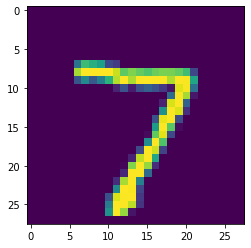

In [46]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.imshow(img.sum(0)[0])

We now take this data (including the time dimension), and pass it to the Sinabs SNN model.

In [47]:
snn_output = sinabs_model(img)

Let us now display the output in time.

Text(0.5, 0, 'Time')

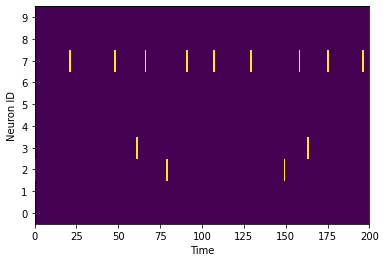

In [49]:
plt.pcolormesh(snn_output.T.detach())

plt.ylabel("Neuron ID")
plt.yticks(np.arange(10) + 0.5, np.arange(10));
plt.xlabel("Time")

As you can see, the majority of spikes are emitted by the output neuron corresponding to the digit 7, which is a correct inference.

## More analysis of the SNN

### Synaptic Operations

One of the factors you might be interested in finding out about your model is the total number of synaptic operations required for an inference. The `Network` class provides a handy method to compute the total number of synaptic operations for the last inference performed by the model.

For instance, in order to look at the total synaptic operations per layer for recognition of image `7` we run the `get_synops` method.

In [50]:
sinabs_model.get_synops()

,Fanout_Prev,In,SynOps,SynOps/s,Time_window
Layer,,,,,
0,500.0,14452.00,7226000.0,36130000.0,200.0
3,800.0,37321.25,29857000.0,149285000.0,200.0
6,1152.0,6589.00,7590528.0,37952640.0,200.0
10,500.0,871.25,435625.0,2178125.0,200.0
12,10.0,1301.00,13010.0,65050.0,200.0


### Comparing activity of the ANN with SNN

['1']
['11']


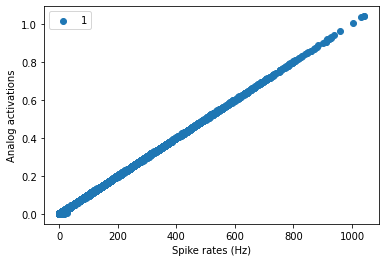

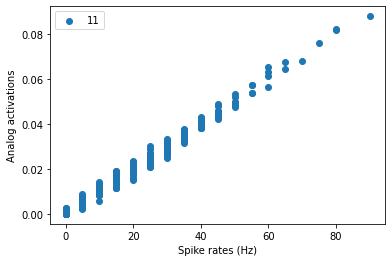

In [51]:
# Generate data to use
for data, label in test_spike_loader:
    break;

cnn_act, spk_act = sinabs_model.plot_comparison(data[0], compute_rate=True, name_list=['1'])
plt.figure()
cnn_act, spk_act = sinabs_model.plot_comparison(data[0], compute_rate=True, name_list=['11'])